# Sentiment Analysis - Labelled Financial News Data

This notebook focuses on conducting sentiment analysis using labeled financial news data. The dataset used in this assignment originates from an automated data scraping framework designed to gather news articles from The Economics Times, a business newspaper from India (although the articles are written in English). Utilizing parallel processing, this framework scrapes articles from the website using a web scraper built with Python's beautifulsoup library. The data extraction process is enhanced with concurrent futures and parallel jobs packages for multiprocessing. This approach facilitated the collection of daily news articles spanning from 2008 to 2022, covering a total of 178 months. The dataset comprises 1,397,114 news articles, each instance containing essential features such as publish date & time, update date , headline, synopsis, sector/genre, and the complete text of the news article. 
(Sources: [Dataset](https://www.kaggle.com/datasets/aravsood7/sentiment-analysis-labelled-financial-news-data); [Article](https://arxiv.org/abs/2312.14978))

The assignment involves analysing the sentiment expressed in financial news articles and categorising them as positive, negative, or neutral. The task includes understanding the characteristics of the dataset, exploring its content, preprocessing the text data, selecting appropriate feature representation techniques, training sentiment classifiers, and evaluating their performance. The objective is to develop accurate sentiment analysis models tailored to the financial domain.

##### The data is sourced from The Economic Times (Excluding the copyrighted Prime Articles)


In [118]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import matplotlib.pyplot as plt
import re
import nltk
from nltk.tokenize import word_tokenize

nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\rnrib\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rnrib\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


First let's load the dataset and take a look at the first few rows.

In [119]:
# Load the data from the CSV file with utf-8 encoding
data = pd.read_csv('data/Fin_cleaned.csv', encoding='utf-8')

# duplicate the data
news = data.copy()

news

,Date_published,Headline,Synopsis,Full_text,Final Status
0,2022-06-21,"Banks holding on to subsidy share, say payment...",The companies have written to the National Pay...,ReutersPayments companies and banks are at log...,Negative
1,2022-04-19,Digitally ready Bank of Baroda aims to click o...,"At present, 50% of the bank's retail loans are...",AgenciesThe bank presently has 20 million acti...,Positive
2,2022-05-27,Karnataka attracted investment commitment of R...,Karnataka is at the forefront in attracting in...,PTIKarnataka Chief Minister Basavaraj Bommai.K...,Positive
3,2022-04-06,Splitting of provident fund accounts may be de...,The EPFO is likely to split accounts only at t...,Getty ImagesThe budget for FY22 had imposed in...,Negative
4,2022-06-14,Irdai weighs proposal to privatise Insurance I...,"Set up in 2009 as an advisory body, IIB collec...",AgenciesThere is a view in the insurance indus...,Positive
...,...,...,...,...,...
395,2022-06-10,"Banks take a cue from RBI, hike lending rates",These banks raised their respective external b...,"PTIICICI Bank, Bank of Baroda, Punjab National...",Negative
396,2022-06-29,Sebi issues Rs 27 lakh recovery notice to indi...,"In the event of non-payment, it will recover t...",ReutersThe logo of the Securities and Exchange...,Negative
397,2022-06-06,Apollo Hospital shares drop 0.68% as Sensex ...,"A total of 10,105 shares changed hands on the ...",Getty ImagesShrikant Chouhan of Kotak Securiti...,Negative
398,2022-05-16,SBI at Rs 710? What makes analysts see up to 5...,Calling the stock 'attractively valued' analys...,AgenciesThe PSU bank reported a 41.27 per cent...,Positive


In [120]:
news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Date_published  400 non-null    object
 1   Headline        400 non-null    object
 2   Synopsis        399 non-null    object
 3   Full_text       400 non-null    object
 4   Final Status    400 non-null    object
dtypes: object(5)
memory usage: 15.8+ KB


There is a missing synopsis value in the dataset.

In [121]:
# print the row with the missing value for the 'synopsis' column
news[news['Synopsis'].isnull()]

,Date_published,Headline,Synopsis,Full_text,Final Status
56,2022-04-08,RBI keeps repo rate unchanged; reduces growth ...,NaN,ANIStory outlineThe benchmark repo rate stands...,Negative


Fill the missing value with an empty string.

In [122]:
# fill the missing value with an empty string
news['Synopsis'] = news['Synopsis'].fillna('')

Let's rename the columns to make it more readable.

In [123]:
# rename columns
news = news.rename(
    columns={'Date_published': 'date', 'Headline': 'headline', 'Synopsis': 'synopsis', 'Full_text': 'text',
             'Final Status': 'label'})
news.head()

,date,headline,synopsis,text,label
0,2022-06-21,"Banks holding on to subsidy share, say payment...",The companies have written to the National Pay...,ReutersPayments companies and banks are at log...,Negative
1,2022-04-19,Digitally ready Bank of Baroda aims to click o...,"At present, 50% of the bank's retail loans are...",AgenciesThe bank presently has 20 million acti...,Positive
2,2022-05-27,Karnataka attracted investment commitment of R...,Karnataka is at the forefront in attracting in...,PTIKarnataka Chief Minister Basavaraj Bommai.K...,Positive
3,2022-04-06,Splitting of provident fund accounts may be de...,The EPFO is likely to split accounts only at t...,Getty ImagesThe budget for FY22 had imposed in...,Negative
4,2022-06-14,Irdai weighs proposal to privatise Insurance I...,"Set up in 2009 as an advisory body, IIB collec...",AgenciesThere is a view in the insurance indus...,Positive


Check what kind of labels we have

In [124]:
# print unique labels and their counts
news.label.value_counts()

label
Positive     215
Negative     184
Positive       1
Name: count, dtype: int64

There are 2 labels for positive values: 'Positive' and 'Positive '. 

In [125]:
# remove the spaces from the labels
news['label'] = news['label'].str.strip()

Now, there are only two correct labels: 'Positive' and 'Negative'. Let's analyse the final class distribution.

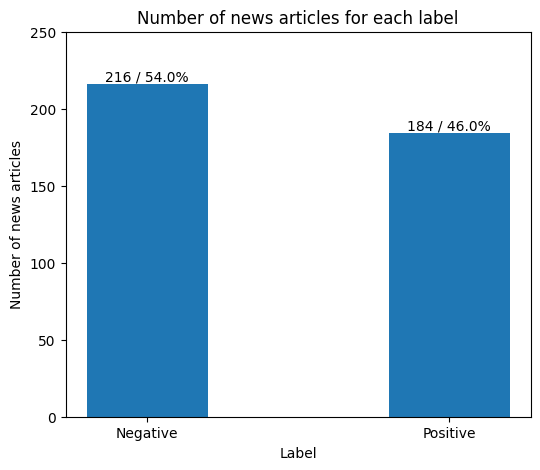

In [126]:
# plot the number of news articles for each label
fig = plt.figure(figsize=(6, 5))
plt.bar(news.label.unique(), news.label.value_counts(), width=0.4)
plt.title('Number of news articles for each label')
plt.xlabel('Label')
plt.ylabel('Number of news articles')
# add the number of news articles on top of each bar
for i, count in enumerate(news.label.value_counts()):
    plt.text(i, count, str(f"{count} / {count / 4}%"), ha='center', va='bottom')
# increase the margin at the top of each bar
plt.ylim(0, 250)
plt.show()

As the plot shows, the class distribution is more or less balanced. 

#### Let's clean the text columns:
- Remove punctuation
- Convert the text to lowercase
- Tokenize the text
- Remove stopwords
- Apply PorterStemmer to the tokens

In [127]:
# list of text columns
text_columns = ['headline', 'synopsis', 'text']
# list to store the word tokens columns
word_tokens_columns = []

# stop words
stop_words = set(stopwords.words('english'))

# initialize the stemmer
stemmer = nltk.PorterStemmer()

# duplicate the data
news_cleaned = news.copy()

for col in text_columns:
    # covert each text column to a string
    news_cleaned[col] = news_cleaned[col].astype(str)
    # remove punctuation and non-alpha characters
    news_cleaned[col] = news_cleaned[col].apply(lambda x: re.sub('[^a-zA-Z]', ' ', x))
    # create a word token column for each text column
    news_cleaned[col + '_word_tokens'] = news_cleaned[col].apply(word_tokenize)
    # add the column to the list
    word_tokens_columns.append(col + '_word_tokens')
    # remove stopwords from the tokens
    news_cleaned[col + '_word_tokens'] = news_cleaned[col + '_word_tokens'].apply(
        lambda tokens: [token for token in tokens if token not in stop_words])
    # apply PorterStemmer to the tokens
    news_cleaned[col + '_word_tokens'] = news_cleaned[col + '_word_tokens'].apply(
        lambda tokens: [stemmer.stem(token) for token in tokens])

# drop not needed columns
news_cleaned = news_cleaned[word_tokens_columns + ['label']]

news_cleaned

,headline_word_tokens,synopsis_word_tokens,text_word_tokens,label
0,"[bank, hold, subsidi, share, say, payment, firm]","[the, compani, written, nation, payment, corp,...","[reuterspay, compani, bank, loggerhead, share,...",Negative
1,"[digit, readi, bank, baroda, aim, click, loan]","[at, present, bank, retail, loan, sourc, digit...","[agenciesth, bank, present, million, activ, us...",Positive
2,"[karnataka, attract, invest, commit, rs, crore...","[karnataka, forefront, attract, invest, wef, m...","[ptikarnataka, chief, minist, basavaraj, bomma...",Positive
3,"[split, provid, fund, account, may, delay]","[the, epfo, like, split, account, time, credit...","[getti, imagesth, budget, fy, impos, incom, ta...",Negative
4,"[irdai, weigh, propos, privatis, insur, inform...","[set, advisori, bodi, iib, collect, transact, ...","[agenciesther, view, insur, industri, iib, abl...",Positive
...,...,...,...,...
395,"[bank, take, cue, rbi, hike, lend, rate]","[these, bank, rais, respect, extern, benchmark...","[ptiicici, bank, bank, baroda, punjab, nation,...",Negative
396,"[sebi, issu, rs, lakh, recoveri, notic, indivi...","[in, event, non, payment, recov, amount, attac...","[reutersth, logo, secur, exchang, board, india...",Negative
397,"[apollo, hospit, share, drop, sensex, fall]","[a, total, share, chang, hand, counter, till, ...","[getti, imagesshrik, chouhan, kotak, secur, sa...",Negative
398,"[sbi, rs, what, make, analyst, see, upsid, stock]","[call, stock, attract, valu, analyst, price, t...","[agenciesth, psu, bank, report, per, cent, yoy...",Positive


Let's see the most frequent words in the text column

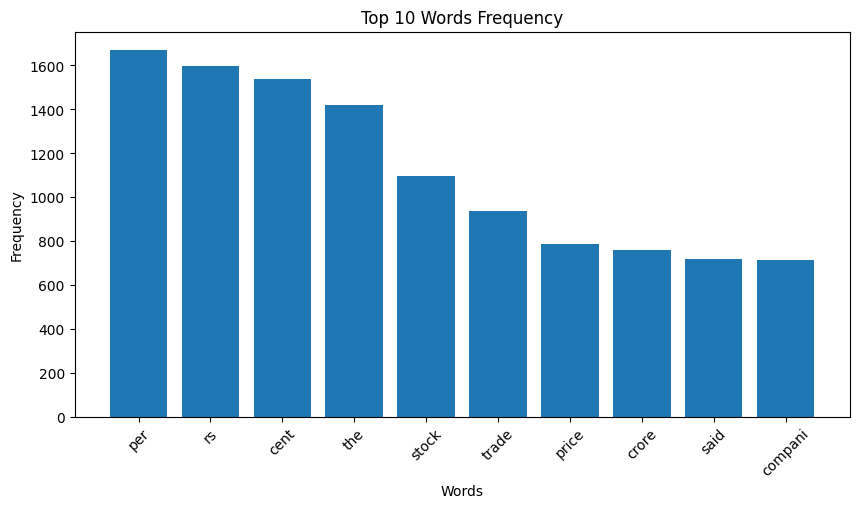

In [128]:
from collections import Counter
from itertools import chain

# Flatten the list of lists
all_words = list(chain.from_iterable(news_cleaned['text_word_tokens']))

# Count the frequency of each word
word_freq = Counter(all_words)

# Get the top N words and their frequencies
top_words = word_freq.most_common(10)

# Extract words and frequencies
top_words, freq = zip(*top_words)

# Plot the bar chart
plt.figure(figsize=(10, 5))
plt.bar(top_words, freq)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 10 Words Frequency')
plt.xticks(rotation=45)
plt.show()

Now, let's see the words with the highest TF-IDF scores.

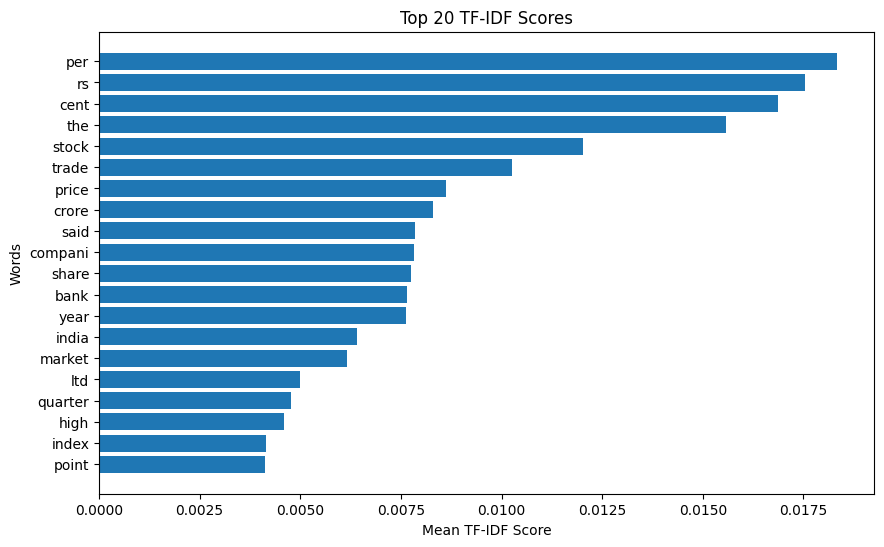

In [129]:
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import numpy as np

# Store all the tokens in a list
doc = news_cleaned['text_word_tokens'].tolist()
# Flatten the list of lists
new_doc = list(chain.from_iterable(doc))

# Convert the tokens to strings
new_doc = [str(element) for element in new_doc]

# Create a TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer()
# Fit and transform the data
tfidf_matrix = tfidf_vectorizer.fit_transform(new_doc)
# Get the feature names
feature_names = tfidf_vectorizer.get_feature_names_out()

# Calculate the mean TF-IDF score for each word
mean_tfidf_scores = np.mean(tfidf_matrix.toarray(), axis=0)

sorted_indices = np.argsort(mean_tfidf_scores)[::-1]
sorted_words = [feature_names[i] for i in sorted_indices]

top_n = 20
top_words = sorted_words[:top_n]
top_scores = mean_tfidf_scores[sorted_indices][:top_n]

plt.figure(figsize=(10, 6))
plt.barh(top_words, top_scores)
plt.xlabel('Mean TF-IDF Score')
plt.ylabel('Words')
plt.title('Top {} TF-IDF Scores'.format(top_n))
plt.gca().invert_yaxis()
plt.show()

Let's create a word cloud to visualize the most frequent words in the text column.

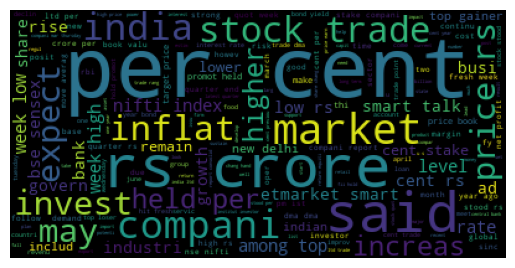

In [130]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

corpus = [word for sublist in news_cleaned['text_word_tokens'] for word in sublist]

wordcloud = WordCloud().generate(" ".join(corpus))

plt.figure()
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

### Train and evaluate models

After having processed and explored the data, we can now train and evaluate sentiment analysis models using the processed data.

In [131]:
# import the required libraries
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from gensim.models import Word2Vec

# duplicate the cleaned data
df = news_cleaned.copy()

df

,headline_word_tokens,synopsis_word_tokens,text_word_tokens,label
0,"[bank, hold, subsidi, share, say, payment, firm]","[the, compani, written, nation, payment, corp,...","[reuterspay, compani, bank, loggerhead, share,...",Negative
1,"[digit, readi, bank, baroda, aim, click, loan]","[at, present, bank, retail, loan, sourc, digit...","[agenciesth, bank, present, million, activ, us...",Positive
2,"[karnataka, attract, invest, commit, rs, crore...","[karnataka, forefront, attract, invest, wef, m...","[ptikarnataka, chief, minist, basavaraj, bomma...",Positive
3,"[split, provid, fund, account, may, delay]","[the, epfo, like, split, account, time, credit...","[getti, imagesth, budget, fy, impos, incom, ta...",Negative
4,"[irdai, weigh, propos, privatis, insur, inform...","[set, advisori, bodi, iib, collect, transact, ...","[agenciesther, view, insur, industri, iib, abl...",Positive
...,...,...,...,...
395,"[bank, take, cue, rbi, hike, lend, rate]","[these, bank, rais, respect, extern, benchmark...","[ptiicici, bank, bank, baroda, punjab, nation,...",Negative
396,"[sebi, issu, rs, lakh, recoveri, notic, indivi...","[in, event, non, payment, recov, amount, attac...","[reutersth, logo, secur, exchang, board, india...",Negative
397,"[apollo, hospit, share, drop, sensex, fall]","[a, total, share, chang, hand, counter, till, ...","[getti, imagesshrik, chouhan, kotak, secur, sa...",Negative
398,"[sbi, rs, what, make, analyst, see, upsid, stock]","[call, stock, attract, valu, analyst, price, t...","[agenciesth, psu, bank, report, per, cent, yoy...",Positive


We need to convert the label column to binary: 1 for "Positive" and 0 for "Negative".

In [132]:
# transform the label column to binary
df['label'] = df['label'].apply(lambda x: 1 if x == 'Positive' else 0)

df

,headline_word_tokens,synopsis_word_tokens,text_word_tokens,label
0,"[bank, hold, subsidi, share, say, payment, firm]","[the, compani, written, nation, payment, corp,...","[reuterspay, compani, bank, loggerhead, share,...",0
1,"[digit, readi, bank, baroda, aim, click, loan]","[at, present, bank, retail, loan, sourc, digit...","[agenciesth, bank, present, million, activ, us...",1
2,"[karnataka, attract, invest, commit, rs, crore...","[karnataka, forefront, attract, invest, wef, m...","[ptikarnataka, chief, minist, basavaraj, bomma...",1
3,"[split, provid, fund, account, may, delay]","[the, epfo, like, split, account, time, credit...","[getti, imagesth, budget, fy, impos, incom, ta...",0
4,"[irdai, weigh, propos, privatis, insur, inform...","[set, advisori, bodi, iib, collect, transact, ...","[agenciesther, view, insur, industri, iib, abl...",1
...,...,...,...,...
395,"[bank, take, cue, rbi, hike, lend, rate]","[these, bank, rais, respect, extern, benchmark...","[ptiicici, bank, bank, baroda, punjab, nation,...",0
396,"[sebi, issu, rs, lakh, recoveri, notic, indivi...","[in, event, non, payment, recov, amount, attac...","[reutersth, logo, secur, exchang, board, india...",0
397,"[apollo, hospit, share, drop, sensex, fall]","[a, total, share, chang, hand, counter, till, ...","[getti, imagesshrik, chouhan, kotak, secur, sa...",0
398,"[sbi, rs, what, make, analyst, see, upsid, stock]","[call, stock, attract, valu, analyst, price, t...","[agenciesth, psu, bank, report, per, cent, yoy...",1


Let's define the models, token columns combinations, and feature representation methods to use in the analysis.


In [133]:
# Define models
models = {
    'Naive Bayes': MultinomialNB(),
    'Logistic Regression': LogisticRegression(max_iter=10000),
    'Decision Trees': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Support Vector Machine': SVC(max_iter=1000),
    'Multi-Layer Perceptron': MLPClassifier(max_iter=5000),
    'XGBoost': XGBClassifier()
}

# Define feature representation methods
feature_methods = {
    'Bag of Words': CountVectorizer(),
    'TF-IDF': TfidfVectorizer(),
    'Word2Vec': Word2Vec()
    # our own embeddings
    # embedding specially for finantial news
}


Let's try and see which combination of columns and which feature representation method gives the best results.

In [134]:
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.exceptions import UndefinedMetricWarning
import warnings

# Suppress UndefinedMetricWarning
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

results = []

train_models = False

if train_models:
    # Outer loop: Iterate through all models
    for model_name, model in models.items():
        print(f'Training and evaluating {model_name}...')
        # Inner loop: Iterate through all token columns combinations
        for i in range(1, len(word_tokens_columns) + 1):
            for j in range(len(word_tokens_columns) - i + 1):
                print(f"  Token columns: {', '.join(word_tokens_columns[j:j + i])}")
                # Select token columns
                selected_columns = word_tokens_columns[j:j + i]

                # Concatenate tokens within each list
                X = df[selected_columns].apply(lambda x: ' '.join([' '.join(item) for item in x]), axis=1)
                y = df['label']

                # Define cross-validation strategy
                cv_outer = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

                for method_name, method in feature_methods.items():
                    if method_name == 'Word2Vec':
                        if model_name in ['Logistic Regression', 'Support Vector Machine', 'Multi-Layer Perceptron',
                                          'XGBoost']:
                            # Train Word2Vec model
                            sentences = [text.split() for text in X]
                            w2v_model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)

                            # Generate embeddings
                            X_embeddings = []
                            for text in X:
                                embedding = [w2v_model.wv[word] for word in text.split() if word in w2v_model.wv]
                                if embedding:
                                    X_embeddings.append(sum(embedding) / len(embedding))
                                else:
                                    # Handle out-of-vocabulary words
                                    X_embeddings.append([0] * w2v_model.vector_size)

                            # Train and evaluate the model using cross-validation
                            scores = cross_validate(model, X_embeddings, y, cv=cv_outer,
                                                    scoring=['accuracy', 'precision_macro', 'recall_macro', 'f1_macro'],
                                                    return_train_score=True)

                        else:
                            # Skip Word2Vec for models that don't support embeddings
                            continue
                    else:
                        # Vectorize text data
                        X_vec = method.fit_transform(X)

                        # Train and evaluate the model using cross-validation
                        scores = cross_validate(model, X_vec, y, cv=cv_outer,
                                                scoring=['accuracy', 'precision_macro', 'recall_macro', 'f1_macro'],
                                                return_train_score=True)

                    # Store the results
                    for fold in range(len(scores['test_accuracy'])):
                        result = {
                            'Model': model_name,
                            'Token Columns': ', '.join(selected_columns),
                            'Feature Representation': method_name,
                            'Fold': fold + 1,
                            'Fit Time': scores['fit_time'][fold],
                            'Score Time': scores['score_time'][fold],
                            'Train Accuracy': scores['train_accuracy'][fold],
                            'Train Precision': scores['train_precision_macro'][fold],
                            'Train Recall': scores['train_recall_macro'][fold],
                            'Train F1-score': scores['train_f1_macro'][fold],
                            'Test Accuracy': scores['test_accuracy'][fold],
                            'Test Precision': scores['test_precision_macro'][fold],
                            'Test Recall': scores['test_recall_macro'][fold],
                            'Test F1-score': scores['test_f1_macro'][fold]
                        }
                        results.append(result)

    # Visualize results
    results_df = pd.DataFrame(results)

    # save the results to a CSV file with the current date in the name
    results_df.to_csv('results/fin_news_sentiment_analysis_results_X_VAl.csv', index=False)

    results_df

## Let's get some insight into the results

In [135]:
# Load X Val results
results_df = pd.read_csv('results/fin_news_sentiment_analysis_results_X_VAl.csv')

In [136]:
# Calculate the average scores for each model and feature representation method
average_results = results_df.groupby(['Model', 'Token Columns', 'Feature Representation']).mean().reset_index()

average_results

,Model,Token Columns,Feature Representation,Fold,Fit Time,Score Time,Train Accuracy,Train Precision,Train Recall,Train F1-score,Test Accuracy,Test Precision,Test Recall,Test F1-score
0,Decision Trees,headline_word_tokens,Bag of Words,3.0,0.008262,0.003647,0.9675,0.966712,0.968611,0.967367,0.7025,0.704958,0.695980,0.695777
1,Decision Trees,headline_word_tokens,TF-IDF,3.0,0.008649,0.003681,0.9675,0.966712,0.968611,0.967367,0.6925,0.698684,0.683345,0.682985
2,Decision Trees,"headline_word_tokens, synopsis_word_tokens",Bag of Words,3.0,0.013847,0.003866,0.9850,0.984530,0.985407,0.984918,0.6875,0.689080,0.683197,0.682522
3,Decision Trees,"headline_word_tokens, synopsis_word_tokens",TF-IDF,3.0,0.017349,0.003469,0.9850,0.984530,0.985407,0.984918,0.6825,0.682797,0.678455,0.678352
4,Decision Trees,"headline_word_tokens, synopsis_word_tokens, te...",Bag of Words,3.0,0.039488,0.003775,1.0000,1.000000,1.000000,1.000000,0.6725,0.671582,0.671264,0.670649
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103,XGBoost,"synopsis_word_tokens, text_word_tokens",TF-IDF,3.0,0.314707,0.011079,1.0000,1.000000,1.000000,1.000000,0.6875,0.690250,0.680202,0.680136
104,XGBoost,"synopsis_word_tokens, text_word_tokens",Word2Vec,3.0,0.180343,0.008923,1.0000,1.000000,1.000000,1.000000,0.5475,0.544307,0.544239,0.543357
105,XGBoost,text_word_tokens,Bag of Words,3.0,0.157003,0.010599,1.0000,1.000000,1.000000,1.000000,0.7225,0.726710,0.716153,0.716270
106,XGBoost,text_word_tokens,TF-IDF,3.0,0.321954,0.009547,1.0000,1.000000,1.000000,1.000000,0.6800,0.683392,0.671113,0.669816


In [137]:
# Find the best model and feature representation method based on the average F1-score
best_results = average_results.sort_values(by='Test F1-score', ascending=False)

best_results.head()

,Model,Token Columns,Feature Representation,Fold,Fit Time,Score Time,Train Accuracy,Train Precision,Train Recall,Train F1-score,Test Accuracy,Test Precision,Test Recall,Test F1-score
96,XGBoost,"headline_word_tokens, synopsis_word_tokens, te...",Bag of Words,3.0,0.151645,0.009534,1.00000,1.00000,1.000000,1.000000,0.7425,0.748258,0.736771,0.736997
97,XGBoost,"headline_word_tokens, synopsis_word_tokens, te...",TF-IDF,3.0,0.315093,0.010857,1.00000,1.00000,1.000000,1.000000,0.7275,0.730878,0.720548,0.721251
105,XGBoost,text_word_tokens,Bag of Words,3.0,0.157003,0.010599,1.00000,1.00000,1.000000,1.000000,0.7225,0.726710,0.716153,0.716270
36,Multi-Layer Perceptron,"headline_word_tokens, synopsis_word_tokens, te...",Bag of Words,3.0,4.270829,0.003535,1.00000,1.00000,1.000000,1.000000,0.7200,0.723121,0.714054,0.714179
93,XGBoost,"headline_word_tokens, synopsis_word_tokens",Bag of Words,3.0,0.067051,0.007753,0.96375,0.96422,0.962905,0.963462,0.7175,0.720953,0.713397,0.712805


As can be seen in the results above, the model with the highest F1-score on the test set is XGBoost, utilizing all the token columns and using the Bag of Words feature representation. It makes sense that using all the token columns will lead to the best result, as all information is used to train the model. 
As for the model that is employed, there are multiple explanations why XGBoost performs the best out of all the evaluated models. First of all, XGBoost uses ensemble learning to improve generalizability and robustness, whereas models as for example, Decision tree and Naive Bayes do not utilize this. Secondly, XGBoost has a wide range of parameters that are tuned, as opposed to models like the Support Vector Machine and the Multi-Layer Perceptron. Lastly, the XGBoost model is able to capture complex relationships in data, that models like Logistic regression and Random forest might not be able to do.
For the feature representation, the Bag of Words (BoW) method outperformed the other ones. One reason for this could be that the BoW model is robust against rare words. BoW captures the frequency of each word in the document, including rare words. In some cases, rare words might be essential for classification, and BoW ensures they are not overlooked. In addition, BoW may capture the relevant information more effectively than TF-IDF or Word2Vec when doing sentiment analysis. BoW can be sufficient to capture the necessary information for classification.

# VADER Analysis

In [138]:
# Import the SentimentIntensityAnalyzer class
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Initialize the Sentiment analyzer
sia = SentimentIntensityAnalyzer()

In [139]:
# Create a new DataFrame to store the sentiment scores
news_vader = news.copy()

# Convert the 'label' column to binary
news_vader['label'] = news_vader['label'].apply(lambda x: 1 if x == 'Positive' else 0)

# Calculate the sentiment score for each news article
news_vader['combined_text'] = news_vader['headline'] + ' ' + news_vader['synopsis'] + ' ' + news_vader['text']

# Calculate the sentiment score for each news article
news_vader['combined_text_sentiment'] = news_vader['combined_text'].apply(lambda x: sia.polarity_scores(x)['compound'])

# Label the sentiment as binary
news_vader['combined_text_sentiment_label'] = news_vader['combined_text_sentiment'].apply(lambda x: 1 if x >= 0 else 0)

news_vader

,date,headline,synopsis,text,label,combined_text,combined_text_sentiment,combined_text_sentiment_label
0,2022-06-21,"Banks holding on to subsidy share, say payment...",The companies have written to the National Pay...,ReutersPayments companies and banks are at log...,0,"Banks holding on to subsidy share, say payment...",0.9774,1
1,2022-04-19,Digitally ready Bank of Baroda aims to click o...,"At present, 50% of the bank's retail loans are...",AgenciesThe bank presently has 20 million acti...,1,Digitally ready Bank of Baroda aims to click o...,0.9460,1
2,2022-05-27,Karnataka attracted investment commitment of R...,Karnataka is at the forefront in attracting in...,PTIKarnataka Chief Minister Basavaraj Bommai.K...,1,Karnataka attracted investment commitment of R...,0.9993,1
3,2022-04-06,Splitting of provident fund accounts may be de...,The EPFO is likely to split accounts only at t...,Getty ImagesThe budget for FY22 had imposed in...,0,Splitting of provident fund accounts may be de...,0.9845,1
4,2022-06-14,Irdai weighs proposal to privatise Insurance I...,"Set up in 2009 as an advisory body, IIB collec...",AgenciesThere is a view in the insurance indus...,1,Irdai weighs proposal to privatise Insurance I...,0.9618,1
...,...,...,...,...,...,...,...,...
395,2022-06-10,"Banks take a cue from RBI, hike lending rates",These banks raised their respective external b...,"PTIICICI Bank, Bank of Baroda, Punjab National...",0,"Banks take a cue from RBI, hike lending rates ...",0.9941,1
396,2022-06-29,Sebi issues Rs 27 lakh recovery notice to indi...,"In the event of non-payment, it will recover t...",ReutersThe logo of the Securities and Exchange...,0,Sebi issues Rs 27 lakh recovery notice to indi...,-0.8020,0
397,2022-06-06,Apollo Hospital shares drop 0.68% as Sensex ...,"A total of 10,105 shares changed hands on the ...",Getty ImagesShrikant Chouhan of Kotak Securiti...,0,Apollo Hospital shares drop 0.68% as Sensex ...,0.9471,1
398,2022-05-16,SBI at Rs 710? What makes analysts see up to 5...,Calling the stock 'attractively valued' analys...,AgenciesThe PSU bank reported a 41.27 per cent...,1,SBI at Rs 710? What makes analysts see up to 5...,0.9983,1


Results of the sentiment analysis using VADER on the complete text of the news articles.

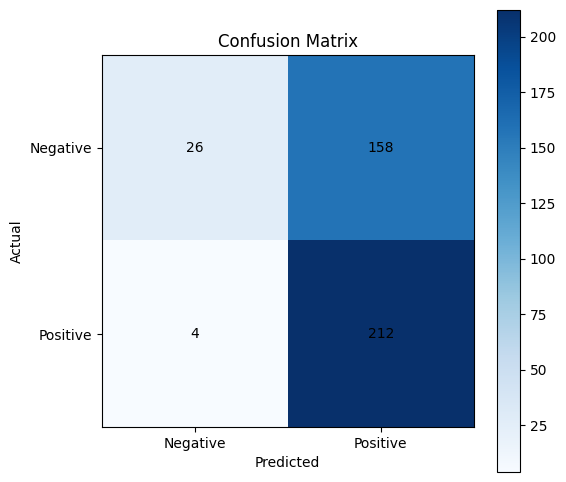

Accuracy: 0.595000
Precision: 0.572973
Recall: 0.981481
F1-score: 0.723549


In [140]:
# Calculate the confusion matrix
conf_matrix = confusion_matrix(news_vader['label'], news_vader['combined_text_sentiment_label'])
# Calculate accuracy, precision, recall, and F1-score
accuracy = (conf_matrix[0, 0] + conf_matrix[1, 1]) / conf_matrix.sum()
precision = precision_score(news_vader['label'], news_vader['combined_text_sentiment_label'])
recall = recall_score(news_vader['label'], news_vader['combined_text_sentiment_label'])
f1 = f1_score(news_vader['label'], news_vader['combined_text_sentiment_label'])

# Store the results
results_vader = [{
    'Column': 'combined_text',
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1-score': f1
}]

# Plot the confusion matrix
plt.figure(figsize=(6, 6))
plt.imshow(conf_matrix, cmap='Blues', interpolation='nearest')
plt.title('Confusion Matrix')
plt.colorbar()
plt.xticks([0, 1], ['Negative', 'Positive'])
plt.yticks([0, 1], ['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
for i in range(2):
    for j in range(2):
        plt.text(j, i, str(conf_matrix[i, j]), ha='center', va='center', color='black')
plt.show()

# Print the results
print(f'Accuracy: {accuracy:.6f}')
print(f'Precision: {precision:.6f}')
print(f'Recall: {recall:.6f}')
print(f'F1-score: {f1:.6f}')



The results show that this analyser is rather good at predicting Positive news, but is not able to capture Negative news as well using the complete text of the news.

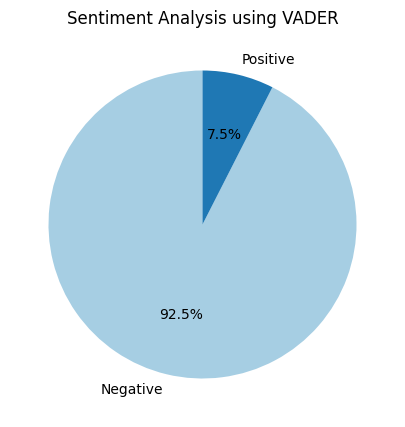

In [141]:
# Plot the sentiment distribution
sentiment_counts = news_vader['combined_text_sentiment_label'].value_counts()
plt.figure(figsize=(8, 5))
plt.pie(sentiment_counts, labels=['Negative', 'Positive'], autopct='%1.1f%%', startangle=90, radius=1,
        colors=plt.cm.Paired.colors)
plt.title('Sentiment Analysis using VADER')
plt.show()

VADER predicted 92.5% of the news articles as negatives and 7.5% as positives.

Let's now analyze the sentiment of the individual text columns.

In [142]:
# Analyse sentiment for the text columns individually
for column in text_columns:
    # Calculate the sentiment score for each news article
    news_vader[column + '_sentiment'] = news_vader[column].apply(lambda x: sia.polarity_scores(str(x))['compound'])

    # Label the sentiment as binary
    news_vader[column + '_sentiment_label'] = news_vader[column + '_sentiment'].apply(lambda x: 1 if x >= 0 else 0)

    # Calculate the confusion matrix
    conf_matrix = confusion_matrix(news_vader['label'], news_vader[column + '_sentiment_label'])

    # Calculate accuracy, precision, recall, and F1-score
    accuracy = (conf_matrix[0, 0] + conf_matrix[1, 1]) / conf_matrix.sum()
    precision = precision_score(news_vader['label'], news_vader[column + '_sentiment_label'])
    recall = recall_score(news_vader['label'], news_vader[column + '_sentiment_label'])
    f1 = f1_score(news_vader['label'], news_vader[column + '_sentiment_label'])

    # Add the results to the results DataFrame
    results_vader.append({
        'Column': column,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-score': f1
    })

# Convert the results to a DataFrame
results_vader = pd.DataFrame(results_vader)

results_vader

,Column,Accuracy,Precision,Recall,F1-score
0,combined_text,0.5950,0.572973,0.981481,0.723549
1,headline,0.5975,0.577031,0.953704,0.719023
2,synopsis,0.5600,0.557803,0.893519,0.686833
3,text,0.5875,0.569106,0.972222,0.717949


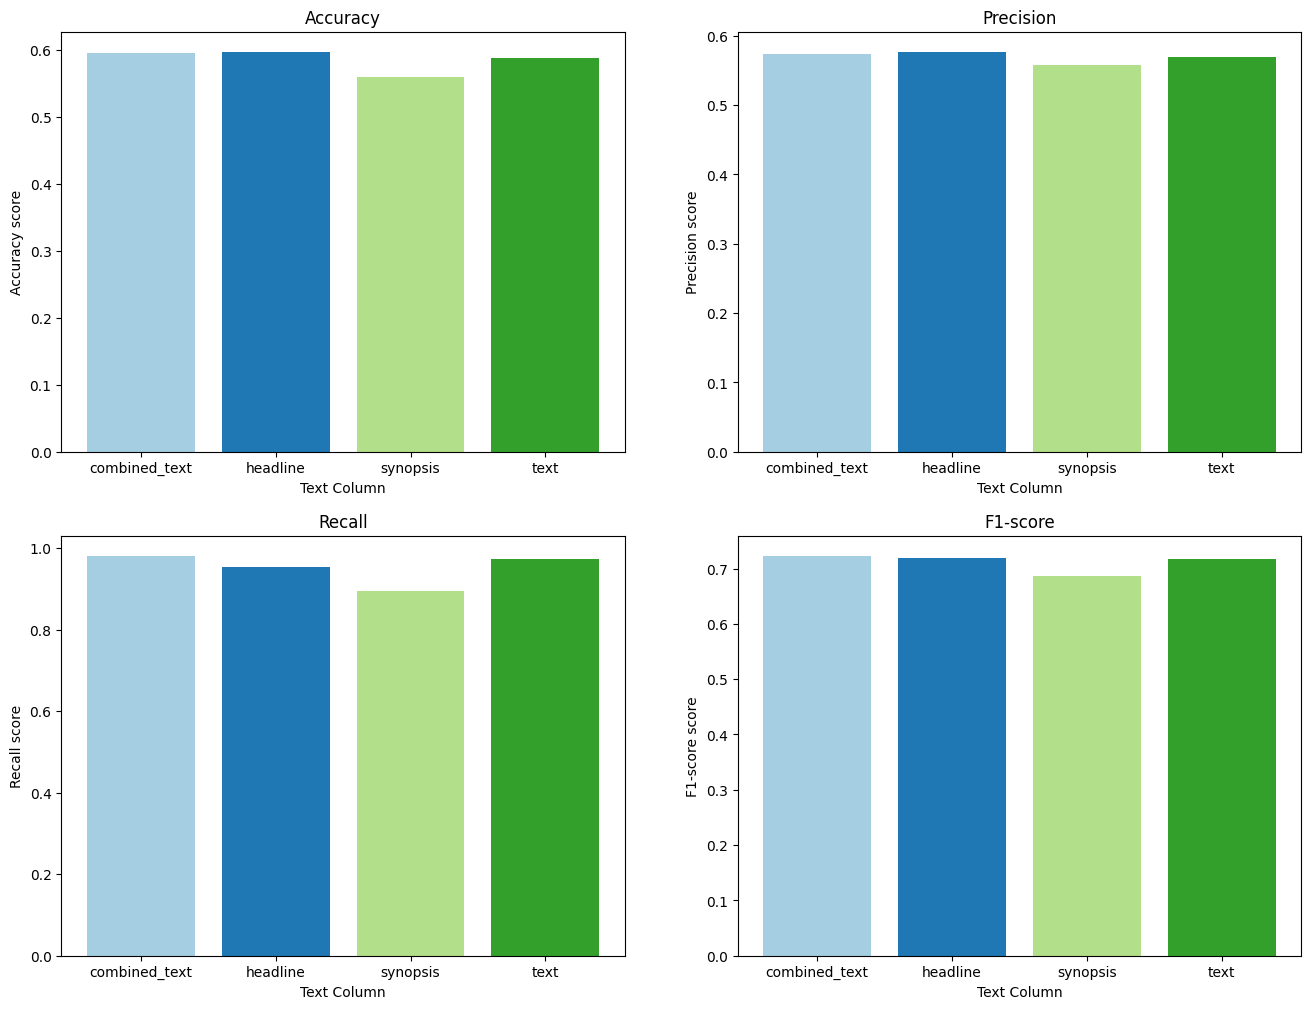

In [143]:
# Create a subplots for each metric to compare the results
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# For each metric, plot the results for each text column
for i, metric in enumerate(['Accuracy', 'Precision', 'Recall', 'F1-score']):
    ax = axes[i // 2, i % 2]
    ax.bar(results_vader['Column'], results_vader[metric], color=plt.cm.Paired.colors)
    ax.set_title(metric)
    ax.set_xlabel('Text Column')
    ax.set_ylabel(f'{metric} score')


Comparison of the sentiment analysis results using VADER on the individual text columns with the complete text.

In [144]:
# Compare the best vader model with the best model from the previous analysis
best_vader_model = results_vader.sort_values(by='F1-score', ascending=False).iloc[0]
best_model = best_results.sort_values(by='Test F1-score', ascending=False).iloc[0]

# Create a table to compare the results
comparison = pd.DataFrame({
    'Model': [best_vader_model['Column'], best_model['Model']],
    'F1-score': [best_vader_model['F1-score'], best_model['Test F1-score']],
    'Accuracy': [best_vader_model['Accuracy'], best_model['Test Accuracy']],
    'Precision': [best_vader_model['Precision'], best_model['Test Precision']],
    'Recall': [best_vader_model['Recall'], best_model['Test Recall']]
}, index=['VADER', 'Best Model'])

comparison

,Model,F1-score,Accuracy,Precision,Recall
VADER,combined_text,0.723549,0.5950,0.572973,0.981481
Best Model,XGBoost,0.736997,0.7425,0.748258,0.736771


The table above shows that the best model from the previous analysis outperforms the best VADER model in all metrics.
This is expected, as the best model from the previous analysis was trained on the data, while VADER is a pre-trained model that might not be as effective for this specific dataset.

# LM Analysis

The following cell executes a parser that analyses the sentiment of the news articles using the Loughran-McDonald Financial Sentiment Dictionary.

This parser was created by the authors of the dictionary and is available [here](LM_Analysis/Generic_Parser.py).

It receives as input the original dataset and analysis all words present in all news and outputs a table with the percentage of words in our dataset that fall in each of the categories considered by the dictionary.

The words are obtained by splitting the text of the news articles and removing punctuation and stopwords. The words are then compared to the dictionary, and the percentage of words in each category is calculated.

The Loughran-McDonald Financial Sentiment Dictionary is a list of words that are commonly used in financial news articles. 

"The sentiment categories are: negative, positive, uncertainty, litigious, strong modal, weak modal, and constraining. The sentiment words are flagged with a number indicating the year in which they were added to the list. Note: A year preceded by a negative sign indicates the year/version when the word was removed from the sentiment category."[1]

The dictionary also contains information about the part of speech of each word and the word's syllables.

Source: [1] [Loughran-McDonald Financial Sentiment Dictionary](https://sraf.nd.edu/loughranmcdonald-master-dictionary/)

In [145]:
!python LM_Analysis/Generic_Parser.py

lm_analysis = pd.read_csv('LM_Analysis/Parser.csv')
lm_analysis



 ...Loading Master Dictionary 5,000
 ...Loading Master Dictionary 10,000
 ...Loading Master Dictionary 15,000
 ...Loading Master Dictionary 20,000
 ...Loading Master Dictionary 25,000
 ...Loading Master Dictionary 30,000
 ...Loading Master Dictionary 35,000
 ...Loading Master Dictionary 40,000
 ...Loading Master Dictionary 45,000
 ...Loading Master Dictionary 50,000
 ...Loading Master Dictionary 55,000
 ...Loading Master Dictionary 60,000
 ...Loading Master Dictionary 65,000
 ...Loading Master Dictionary 70,000
 ...Loading Master Dictionary 75,000
 ...Loading Master Dictionary 80,000
 ...Loading Master Dictionary 85,000

Master Dictionary loaded from file:
  LoughranMcDonald_MasterDictionary_2023.csv

  master_dictionary has 86,531 words.



Fri Mar 22 15:54:53 2024
PROGRAM NAME: LM_Analysis/Generic_Parser.py

1 : Data/Fin_Cleaned.csv


Runtime: 0:00:00.243630

Normal termination.
Fri Mar 22 15:54:53 2024


,file name,file size,number of words,% negative,% positive,% uncertainty,% litigious,% strong modal,% weak modal,% constraining,# of alphabetic,# of digits,# of numbers,avg # of syllables per word,average word length,vocabulary
0,Data/Fin_Cleaned.csv,991089,132340,1.742481,1.247544,0.776787,0.307541,0.448844,0.411062,0.159438,740297,39609,11673,1.576341,4.864349,6579


## In short, our analysis follows the following steps:

1. Access the lexicon used by VADER and save it to a CSV file.
2. Create a new lexicon set using the Loughran-McDonald Master Dictionary with the following columns: Word, Sentiment Score.
3. Create a final lexicon set that combines the VADER and Loughran-McDonald lexicons abiding by the following rules:
    - Words that are only present in the VADER lexicon set are kept with their respective scores.
    - Common words are kept, but the score is overwritten to the Loughran-McDonald score.
    - Words exclusive to Loughran-McDonald are kept with their respective scores.
4. Classify the news articles using the final lexicon set and evaluate its performance.

##### 1. Save the VADER lexicon to a CSV file

In [146]:
import csv

# Access the VADER lexicon
vader_lexicon = sia.lexicon

with open('lexicons/vader_lexicon.csv', 'w', newline='', encoding='utf-8') as csvfile:
    fieldnames = ['Word', 'Sentiment Score']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

    writer.writeheader()
    for word, score in vader_lexicon.items():
        writer.writerow({'Word': word, 'Sentiment Score': score})

##### 2. Create a new lexicon set using the Loughran-McDonald Master Dictionary

In [147]:
# Load the CSV file containing the dictionary
lm_dictionary = pd.read_csv('LM_Analysis/LoughranMcDonald_MasterDictionary_2023.csv')

lm_dictionary

,Word,Seq_num,Word Count,Word Proportion,Average Proportion,Std Dev,Doc Count,Negative,Positive,Uncertainty,Litigious,Strong_Modal,Weak_Modal,Constraining,Syllables,Source
0,AARDVARK,1,354,1.550080e-08,1.422600e-08,3.815486e-06,99,0,0,0,0,0,0,0,2,12of12inf
1,AARDVARKS,2,3,1.313627e-10,8.653817e-12,9.241714e-09,1,0,0,0,0,0,0,0,2,12of12inf
2,ABACI,3,9,3.940882e-10,1.169679e-10,5.290465e-08,7,0,0,0,0,0,0,0,3,12of12inf
3,ABACK,4,29,1.269840e-09,6.654735e-10,1.595100e-07,28,0,0,0,0,0,0,0,2,12of12inf
4,ABACUS,5,8570,3.752595e-07,3.809464e-07,3.529356e-05,1108,0,0,0,0,0,0,0,3,12of12inf
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86526,ZYGOTE,86529,50,2.189379e-09,8.729336e-10,1.886011e-07,35,0,0,0,0,0,0,0,2,12of12inf
86527,ZYGOTES,86530,1,4.378757e-11,1.809516e-11,1.932446e-08,1,0,0,0,0,0,0,0,2,12of12inf
86528,ZYGOTIC,86531,0,0.000000e+00,0.000000e+00,0.000000e+00,0,0,0,0,0,0,0,0,3,12of12inf
86529,ZYMURGIES,86532,0,0.000000e+00,0.000000e+00,0.000000e+00,0,0,0,0,0,0,0,0,3,12of12inf


In [148]:
# Define the columns to keep
selected_columns = ['Word', 'Negative', 'Positive']

# Select only the necessary columns
lm_lexicon = lm_dictionary[selected_columns]

lm_lexicon

,Word,Negative,Positive
0,AARDVARK,0,0
1,AARDVARKS,0,0
2,ABACI,0,0
3,ABACK,0,0
4,ABACUS,0,0
...,...,...,...
86526,ZYGOTE,0,0
86527,ZYGOTES,0,0
86528,ZYGOTIC,0,0
86529,ZYMURGIES,0,0


In [149]:
# Check if there are any word classified in both categories
double_classification = lm_lexicon[(lm_lexicon['Negative'] != 0) & (lm_lexicon['Positive'] != 0)]

# Print the number of words classified in both categories
print(f'Number of words classified in both categories: {double_classification.shape[0]}')

Number of words classified in both categories: 0


In [150]:
# Print value counts for the 'Negative' column
lm_lexicon['Negative'].value_counts()

Negative
 0       84176
 2009     2305
 2014       26
 2011       13
-2020       10
 2012        1
Name: count, dtype: int64

In [151]:
# Print value counts for the 'Positive' column
lm_lexicon['Positive'].value_counts()

Positive
 0       86177
 2009      345
-2020        7
 2012        1
 2011        1
Name: count, dtype: int64

As we can see, the words are classified as negative or positive based on the year they were classified as such.

A negative year indicates that the word was removed from the sentiment category in that year.

As such, and since there are no double classifications, we can proceed to calculate the sentiment score for each word.

In [152]:
# Convert the 'Negative' and 'Positive' columns to binary values: 0 if the current value is 0 or a negative year and 1 if the current value is a positive year
lm_lexicon.loc[lm_lexicon['Positive'] > 0, 'Positive'] = 1
lm_lexicon.loc[lm_lexicon['Positive'] <= 0, 'Positive'] = 0

lm_lexicon.loc[lm_lexicon['Negative'] > 0, 'Negative'] = 1
lm_lexicon.loc[lm_lexicon['Negative'] <= 0, 'Negative'] = 0

# Calculate the Sentiment Score
lm_lexicon['Sentiment Score'] = lm_lexicon['Positive'] - lm_lexicon['Negative']

# Drop the Negative and Positive columns
lm_lexicon = lm_lexicon.drop(columns=['Negative', 'Positive'])

# Remove words with a sentiment score of 0
lm_lexicon = lm_lexicon[lm_lexicon['Sentiment Score'] != 0]

# Lowercase the words
lm_lexicon['Word'] = lm_lexicon['Word'].str.lower()

# Save the new lexicon to 'lm_lexicon.csv'
lm_lexicon.to_csv('lexicons/lm_lexicon.csv', index=False)

##### 3. Create a final lexicon set that combines the VADER and Loughran-McDonald lexicons

In [153]:
# Load the lexicon files
vader_lexicon_path = 'lexicons/vader_lexicon.csv'
lm_lexicon_path = 'lexicons/lm_lexicon.csv'
vader_lexicon = pd.read_csv(vader_lexicon_path)
lm_lexicon = pd.read_csv(lm_lexicon_path)

# Merge the lexicons
final_lexicon = pd.merge(vader_lexicon, lm_lexicon, on='Word', how='outer', suffixes=('_vader', '_lm'))

# Create a new column 'Sentiment Score' that combines the scores from the VADER and Loughran-McDonald lexicons
final_lexicon['Sentiment Score'] = final_lexicon['Sentiment Score_lm'].fillna(
    final_lexicon['Sentiment Score_vader'])

# Drop the 'Sentiment Score_vader' and 'Sentiment Score_lm' columns
final_lexicon = final_lexicon.drop(columns=['Sentiment Score_vader', 'Sentiment Score_lm'])

# Export the final lexicon to a CSV file
final_lexicon.to_csv('lexicons/final_lexicon.csv', index=False)

final_lexicon

,Word,Sentiment Score
0,$:,-1.5
1,%),-0.4
2,%-),-1.5
3,&-:,-0.4
4,&:,-0.7
...,...,...
9331,}:,-2.1
9332,}:(,-2.0
9333,}:),0.4
9334,}:-(,-2.1


##### 4. Classify the news articles using the final lexicon set

In [154]:
# Duplicate the data
news_lm = news.copy()

# Convert the 'label' column to binary
news_lm['label'] = news_lm['label'].apply(lambda x: 1 if x == 'Positive' else 0)

# Combine the text columns
news_lm['combined_text'] = news_lm['headline'] + ' ' + news_lm['synopsis'] + ' ' + news_lm['text']

# Tokenize the text
news_lm['combined_text_word_tokens'] = news_lm['combined_text'].apply(word_tokenize)

# Function to calculate the sentiment score for each news article
def calculate_sentiment_score(tokens):
    word_sentiments = final_lexicon.loc[final_lexicon['Word'].isin(tokens)]['Sentiment Score']
    sentiment_score = sum(word_sentiments)
    return sentiment_score

# Calculate the sentiment score for each news article
news_lm['combined_text_sentiment'] = news_lm['combined_text_word_tokens'].apply(
    calculate_sentiment_score)

# Label the sentiment as binary
news_lm['combined_text_sentiment_label'] = news_lm['combined_text_sentiment'].apply(
    lambda x: 1 if x >= 0 else 0)

news_lm

,date,headline,synopsis,text,label,combined_text,combined_text_word_tokens,combined_text_sentiment,combined_text_sentiment_label
0,2022-06-21,"Banks holding on to subsidy share, say payment...",The companies have written to the National Pay...,ReutersPayments companies and banks are at log...,0,"Banks holding on to subsidy share, say payment...","[Banks, holding, on, to, subsidy, share, ,, sa...",8.5,1
1,2022-04-19,Digitally ready Bank of Baroda aims to click o...,"At present, 50% of the bank's retail loans are...",AgenciesThe bank presently has 20 million acti...,1,Digitally ready Bank of Baroda aims to click o...,"[Digitally, ready, Bank, of, Baroda, aims, to,...",7.5,1
2,2022-05-27,Karnataka attracted investment commitment of R...,Karnataka is at the forefront in attracting in...,PTIKarnataka Chief Minister Basavaraj Bommai.K...,1,Karnataka attracted investment commitment of R...,"[Karnataka, attracted, investment, commitment,...",34.3,1
3,2022-04-06,Splitting of provident fund accounts may be de...,The EPFO is likely to split accounts only at t...,Getty ImagesThe budget for FY22 had imposed in...,0,Splitting of provident fund accounts may be de...,"[Splitting, of, provident, fund, accounts, may...",8.8,1
4,2022-06-14,Irdai weighs proposal to privatise Insurance I...,"Set up in 2009 as an advisory body, IIB collec...",AgenciesThere is a view in the insurance indus...,1,Irdai weighs proposal to privatise Insurance I...,"[Irdai, weighs, proposal, to, privatise, Insur...",9.5,1
...,...,...,...,...,...,...,...,...,...
395,2022-06-10,"Banks take a cue from RBI, hike lending rates",These banks raised their respective external b...,"PTIICICI Bank, Bank of Baroda, Punjab National...",0,"Banks take a cue from RBI, hike lending rates ...","[Banks, take, a, cue, from, RBI, ,, hike, lend...",16.0,1
396,2022-06-29,Sebi issues Rs 27 lakh recovery notice to indi...,"In the event of non-payment, it will recover t...",ReutersThe logo of the Securities and Exchange...,0,Sebi issues Rs 27 lakh recovery notice to indi...,"[Sebi, issues, Rs, 27, lakh, recovery, notice,...",-2.7,0
397,2022-06-06,Apollo Hospital shares drop 0.68% as Sensex ...,"A total of 10,105 shares changed hands on the ...",Getty ImagesShrikant Chouhan of Kotak Securiti...,0,Apollo Hospital shares drop 0.68% as Sensex ...,"[Apollo, Hospital, shares, drop, 0.68, %, as, ...",2.8,1
398,2022-05-16,SBI at Rs 710? What makes analysts see up to 5...,Calling the stock 'attractively valued' analys...,AgenciesThe PSU bank reported a 41.27 per cent...,1,SBI at Rs 710? What makes analysts see up to 5...,"[SBI, at, Rs, 710, ?, What, makes, analysts, s...",25.2,1


Results of the sentiment analysis using the Loughran-McDonald Financial Sentiment Dictionary on the complete text of the news articles.

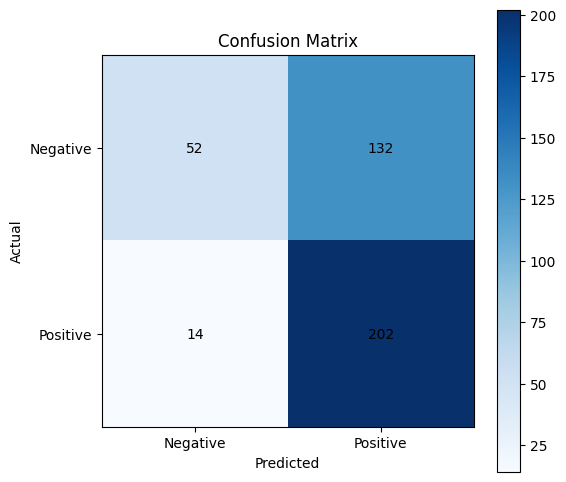

Accuracy: 0.635000
Precision: 0.604790
Recall: 0.935185
F1-score: 0.734545


In [155]:
# Calculate the confusion matrix
conf_matrix = confusion_matrix(news_lm['label'], news_lm['combined_text_sentiment_label'])

# Calculate accuracy, precision, recall, and F1-score
accuracy = (conf_matrix[0, 0] + conf_matrix[1, 1]) / conf_matrix.sum()
precision = precision_score(news_lm['label'], news_lm['combined_text_sentiment_label'])
recall = recall_score(news_lm['label'], news_lm['combined_text_sentiment_label'])
f1 = f1_score(news_lm['label'], news_lm['combined_text_sentiment_label'])

# Store the results
results_lm = [{
    'Column': 'combined_text',
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1-score': f1
}]

# Plot the confusion matrix
plt.figure(figsize=(6, 6))
plt.imshow(conf_matrix, cmap='Blues', interpolation='nearest')
plt.title('Confusion Matrix')
plt.colorbar()
plt.xticks([0, 1], ['Negative', 'Positive'])
plt.yticks([0, 1], ['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
for i in range(2):
    for j in range(2):
        plt.text(j, i, str(conf_matrix[i, j]), ha='center', va='center', color='black')
plt.show()

# Print the results
print(f'Accuracy: {accuracy:.6f}')
print(f'Precision: {precision:.6f}')
print(f'Recall: {recall:.6f}')
print(f'F1-score: {f1:.6f}')

